#Question 1
a) the air temperature (in F) and cloud cover (in %) in Florence, OR (in 2020) on January 31, 2020?
Air temperature in Florence on Jan 31st, 2020 = 53.82 F

b) the air temperature (in F) and cloud cover (in %) in Eugene, OR (in 2020) on February 15, 2020?
Cloud cover in Florence on Jan 31st, 2020 = 99.98 %


#Question 2
a) Highest average air temperature (i.e. hottest place)
Plan de Ayala, Sonora Mexico

b) Lowest average air temperature (i.e. coldest place)
Cody, Wyoming

c) Highest average cloudiness (i.e. cloudiest place)
Port Albernie, B.C. Canada

d) Lowest average cloudiest (i.e. least cloudy place)
Baja California, Mexico (The Gulf of Mexico)

e) Place with highest range in air temperature
Girardville, Quebec Canada

f) Place with the absolute coldest temperature on a single day
The Min temperature location is Galata, MT 59444


In [1]:
# Import packages
import os
import glob

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import rasterio
import xarray

In [2]:
# Define filepath
filepath = '/Users/chasekrogh/Documents/geospatial-data-science/labs/lab4/dataforlab4/'

# Define list of Landsat bands
files = sorted(glob.glob(filepath + 'landsat/*.tif'))
print(files)

['/Users/chasekrogh/Documents/geospatial-data-science/labs/lab4/dataforlab4/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B1.tif', '/Users/chasekrogh/Documents/geospatial-data-science/labs/lab4/dataforlab4/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B2.tif', '/Users/chasekrogh/Documents/geospatial-data-science/labs/lab4/dataforlab4/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B3.tif', '/Users/chasekrogh/Documents/geospatial-data-science/labs/lab4/dataforlab4/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B4.tif', '/Users/chasekrogh/Documents/geospatial-data-science/labs/lab4/dataforlab4/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B5.tif', '/Users/chasekrogh/Documents/geospatial-data-science/labs/lab4/dataforlab4/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B6.tif', '/Users/chasekrogh/Documents/geospatial-data-science/labs/lab4/dataforlab4/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B7.tif', '/Users/chasekrogh/Documents/geospatial-data-sc

In [3]:
# Open a single band
src = rasterio.open(files[0])
band_1 = src.read(1)

In [4]:
# Find metadata (e.g. driver, data type, coordinate reference system, transform etc.)
print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 1208, 'height': 1422, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 391695.0,
       0.0, -30.0, 4880565.0), 'tiled': False, 'interleave': 'band'}


In [5]:
# Find coordinate reference system
src.crs # https://epsg.io/32610

CRS.from_epsg(32610)

In [6]:
# Find format
src.driver

'GTiff'

In [7]:
# Find pixel size
src.transform[0]

30.0

In [8]:
# Find bounds of dataset
src.bounds

BoundingBox(left=391695.0, bottom=4837905.0, right=427935.0, top=4880565.0)

In [9]:
# Get corners of dataset
full_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
print(full_extent)

[391695.0, 427935.0, 4837905.0, 4880565.0]


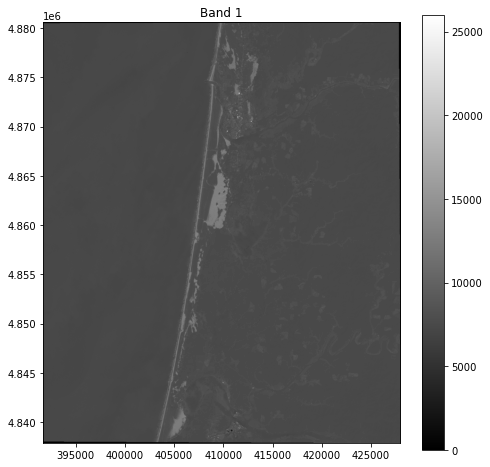

In [10]:
# Plot dataset
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(band_1, cmap='gray', extent=full_extent)
ax.set_title("Band 1")
fig.colorbar(im, orientation='vertical')
plt.show()

In [11]:
# Find number of columns and rows in array
band_1.shape

(1422, 1208)

In [12]:
# Find total number of pixels in array
band_1.size

1717776

In [13]:
# Find maximum value in array
band_1.max()

25983

In [14]:
# Find datatype
band_1.dtype

dtype('uint16')

In [15]:
# Find maximum possible value in array
2**16

65536

In [16]:
# Find file size (in MB)
band_1.nbytes / 1000000

3.435552

In [17]:
# Open all bands in a loop
list_bands = []
for file in files:
    # Read band
    src = rasterio.open(file)
    band = src.read(1)
    
    # Append to list
    list_bands.append(band)

# Convert from list of arrays to n-dimensional array
all_bands = np.dstack(list_bands)

In [18]:
all_bands.shape

(1422, 1208, 8)

In [19]:
# Convert values to a range of 0-255
all_bands_image = np.uint8((all_bands / 65536) * 255)

In [20]:
# Produce a new array by stacking the RGB bands
rgb = np.dstack((all_bands_image[:,:,3],all_bands_image[:,:,2],all_bands_image[:,:,1]))

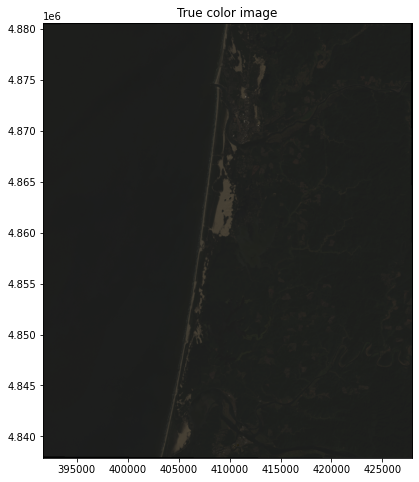

In [21]:
# Plot as RGB image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(rgb, extent=full_extent)
ax.set_title("True color image")
plt.show()

In [22]:
# Compute NDWI
np.seterr(divide='ignore', invalid='ignore')
ndwi = np.divide((all_bands[:,:,2].astype(float) - all_bands[:,:,4].astype(float)), \
                 (all_bands[:,:,2].astype(float) + all_bands[:,:,4].astype(float)))

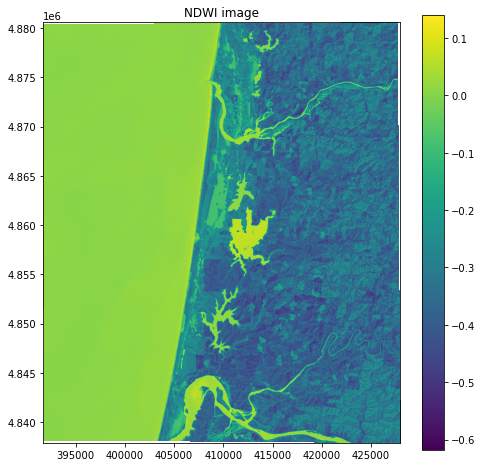

In [23]:
# Plot NDWI image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(ndwi, extent=full_extent)
ax.set_title("NDWI image")
fig.colorbar(im, orientation='vertical')
plt.show()

In [24]:
# Write an array as a raster band to a new 8-bit file. For the new file's profile, 
# we start with the profile of the source
profile = src.profile

# And then change the band count to 3, set the dtype to uint8, and specify LZW compression.
profile.update(dtype=rasterio.uint8, count=3, compress='lzw')

In [25]:
with rasterio.open(filepath + 'landsat/rgb.tif', 'w', **profile) as dst:
    # Write array
    dst.write(np.rollaxis(rgb, axis=2)) # Note that array needs to be in bands, rows, cols order (z, y, x)

In [26]:
filepath

'/Users/chasekrogh/Documents/geospatial-data-science/labs/lab4/dataforlab4/'

In [27]:
# Read data
xds = xarray.open_dataset(filepath + 'era/usa_t2m_tcc_2020.nc', decode_coords='all')

In [28]:
xds

<xarray.Dataset>
Dimensions:    (longitude: 233, latitude: 99, time: 1464)
Coordinates:
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -67.5 -67.25 -67.0
  * latitude   (latitude) float32 49.24 48.99 48.74 48.49 ... 25.24 24.99 24.74
  * time       (time) datetime64[ns] 2020-01-01 ... 2020-12-31T18:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    tcc        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-01-05 17:55:44 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

In [29]:
# Print the time period of the data
print('The data ranges from %s to %s' %(xds['t2m']['time'].values.min(), xds['t2m']['time'].values.max()))

The data ranges from 2020-01-01T00:00:00.000000000 to 2020-12-31T18:00:00.000000000


In [30]:
xds_daily = xds.resample(time='1D').mean()
xds_daily

<xarray.Dataset>
Dimensions:    (time: 366, longitude: 233, latitude: 99)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -67.5 -67.25 -67.0
  * latitude   (latitude) float32 49.24 48.99 48.74 48.49 ... 25.24 24.99 24.74
Data variables:
    t2m        (time, latitude, longitude) float32 280.6 281.4 ... 296.3 296.2
    tcc        (time, latitude, longitude) float32 0.9765 0.8814 ... 0.2124

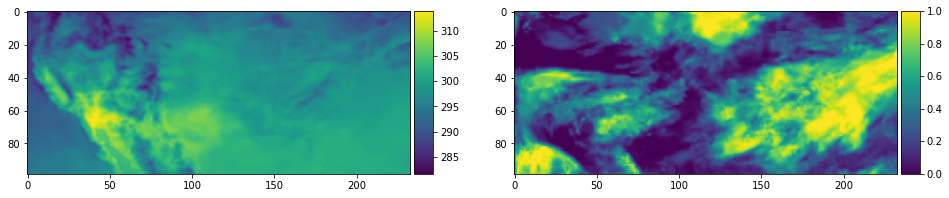

In [31]:
# Plot data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
im1 = ax1.imshow(xds_daily['t2m'][226,:,:])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax2.imshow(xds_daily['tcc'][226,:,:])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

In [32]:
# Next, find the index of the grid point nearest a specific lat/lon.   
florence_weather = xds_daily.sel(latitude=43.974659, longitude=-124.103142, method='nearest')

/Users/chasekrogh/opt/anaconda3/envs/lab4/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/chasekrogh/opt/anaconda3/envs/lab4/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


In [33]:
# Note: Aug 14 is DOY 226
print('Cloud cover in Florence on Aug 14, 2020 = %.2f %%' % (florence_weather['tcc'][226].values * 100))

Cloud cover in Florence on Aug 14, 2020 = 0.02 %


In [34]:
fahrenheit = (florence_weather['t2m'][226].values - 273.15) * 9/5 + 32
print('Air temperature in Florence on Aug 14, 2020 = %.2f F' % (fahrenheit))

Air temperature in Florence on Aug 14, 2020 = 62.25 F


Text(0, 0.5, 'Cloud cover (%)')

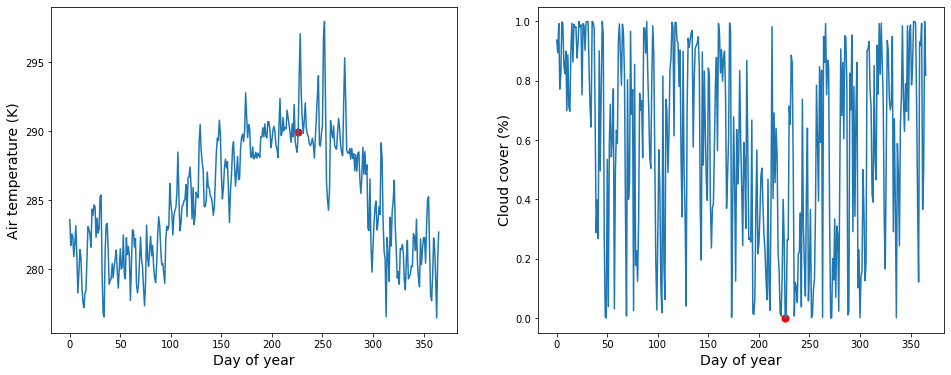

In [35]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.plot(florence_weather['t2m'])
ax1.scatter(226, florence_weather['t2m'][226], s=50, color='r')
ax1.set_xlabel('Day of year', fontsize=14)
ax1.set_ylabel('Air temperature (K)', fontsize=14)

ax2.plot(florence_weather['tcc'])
ax2.scatter(226, florence_weather['tcc'][226], s=50, color='r')
ax2.set_xlabel('Day of year', fontsize=14)
ax2.set_ylabel('Cloud cover (%)', fontsize=14)

In [36]:
mean_temp = (florence_weather['t2m'].mean() - 273.15) * 9/5 + 32
print('Mean air temp. in Florence in 2020 = %.2f F' % (mean_temp))

Mean air temp. in Florence in 2020 = 53.55 F


In [37]:
mean_cloud = florence_weather['tcc'].mean()
print('Mean cloud cover in Florence in 2020 = %.2f %%' % (mean_cloud * 100))

Mean cloud cover in Florence in 2020 = 58.76 %


In [38]:
days = np.sum(florence_weather['tcc'] < 0.2).values
print('There were %.0f days with less than 20%% cloud cover in 2020' % days)

There were 61 days with less than 20% cloud cover in 2020


# Question 1

# a) the air temperature (in F) and cloud cover (in %) in Florence, OR (in 2020) on January 31, 2020?

In [39]:
#code for calculating temp in Florence on 1/31/20
fahrenheit = (florence_weather['t2m'][30].values - 273.15) * 9/5 + 32
print('Air temperature in Florence on Jan 31st, 2020 = %.2f F' % (fahrenheit))
#code for calculating cloud cover in Florence on 1/31/20
print('Cloud cover in Florence on Jan 31st, 2020 = %.2f %%' % (florence_weather['tcc'][30].values * 100))


Air temperature in Florence on Jan 31st, 2020 = 53.82 F
Cloud cover in Florence on Jan 31st, 2020 = 99.98 %


# b) the air temperature (in F) and cloud cover (in %) in Eugene, OR (in 2020) on February 15, 2020?

In [40]:
#code for calculating temp in Eugene on 2/15/20
eugene_weather = xds_daily.sel(latitude=44.0521, longitude=-123.0868, method='nearest')
fahrenheit = (eugene_weather['t2m'][45].values - 273.15) * 9/5 + 32
print('Air temperature in Eugene on Feb 15th, 2020 = %.2f F' % (fahrenheit))

Air temperature in Eugene on Feb 15th, 2020 = 42.00 F


/Users/chasekrogh/opt/anaconda3/envs/lab4/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/chasekrogh/opt/anaconda3/envs/lab4/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


In [41]:
#code for calculating cloud cover in Eugene on 2/15/20
print('Cloud cover in Eugene on Feb 15th, 2020 = %.2f %%' % (eugene_weather['tcc'][45].values * 100))

Cloud cover in Eugene on Feb 15th, 2020 = 99.99 %


# Question 2

# a) Highest average air temperature (i.e. hottest place) Answer: Plan de Ayala, Sonora Mexico

In [42]:
mean = (xds_daily['t2m'].mean(dim='time')-273.15)*(9/5)+32
mean_max = mean.argmax()
print(mean_max)



<xarray.DataArray 't2m' ()>
array(18928)


In [43]:
high_idx = np.unravel_index(mean_max, xds_daily['t2m'].shape)
print(high_idx)

(0, 81, 55)


In [44]:
(mean[81,55])

<xarray.DataArray 't2m' ()>
array(79.06801, dtype=float32)
Coordinates:
    longitude  float32 -111.2
    latitude   float32 28.99

# b) Lowest average air temperature (i.e. coldest place) Answer: Cody, Wyoming

In [45]:
mean = (xds_daily['t2m'].mean(dim='time')-273.15)*(9/5)+32
mean_min = mean.argmin()
print(mean_min)

<xarray.DataArray 't2m' ()>
array(4954)


In [46]:
low_idx = np.unravel_index(mean_min, xds_daily['t2m'].shape)
print(low_idx)

(0, 21, 61)


In [47]:
(mean[21,61])

<xarray.DataArray 't2m' ()>
array(29.179205, dtype=float32)
Coordinates:
    longitude  float32 -109.8
    latitude   float32 43.99

# c) Highest average cloudiness (i.e. cloudiest place) Answer: Port Albernie, B.C. Canada

In [48]:
mean = xds_daily['tcc'].mean(dim='time')
mean_max = mean.argmax()
print(mean_max)

<xarray.DataArray 'tcc' ()>
array(0)


In [49]:
high_idx = np.unravel_index(mean_max, xds_daily['tcc'].shape)
print(high_idx)

(0, 0, 0)


In [50]:
(mean[0,0])

<xarray.DataArray 'tcc' ()>
array(0.77146894, dtype=float32)
Coordinates:
    longitude  float32 -125.0
    latitude   float32 49.24

# d) Lowest average cloudiest (i.e. least cloudy place) answer: Baja California, Mexico

In [51]:
mean = xds_daily['tcc'].mean(dim='time')
mean_min = mean.argmin()
print(mean_max)

<xarray.DataArray 'tcc' ()>
array(0)


In [52]:
high_idx = np.unravel_index(mean_min, xds_daily['tcc'].shape)
print(high_idx)

(0, 71, 41)


In [53]:
(mean[71,41])

<xarray.DataArray 'tcc' ()>
array(0.16893195, dtype=float32)
Coordinates:
    longitude  float32 -114.8
    latitude   float32 31.49

# e) Place with highest range in air temperature answer: Girardville, Quebec Canada

In [54]:
daily_max = np.max(xds_daily['t2m'],axis=0)
daily_max
daily_min = np.min(xds_daily['t2m'],axis=0)
daily_min
temprange = (daily_max - daily_min)
temprange
high_range = temprange.argmax()
high_range
high_range_idx = np.unravel_index(high_range,xds_daily['t2m'].shape)
print(high_range_idx)

(0, 1, 210)


In [55]:
(mean[1,210])

<xarray.DataArray 'tcc' ()>
array(0.6921238, dtype=float32)
Coordinates:
    longitude  float32 -72.5
    latitude   float32 48.99

# f) Place with the absolute coldest temperature on a single day answer: Whitlash, Montana

In [66]:
daily_max = np.max(xds_daily['t2m'],axis =0)
daily_min = np.min(xds_daily['t2m'],axis =0)
temp_range = daily_max - daily_min
max_range = temp_range.argmax()
max_range_index = np.unravel_index(max_range, np.max(xds_daily['t2m'], axis = 0).shape)
max_range_index
max_range_loc = np.max(xds_daily['t2m'], axis=0)[max_range_index]
max_range_loc

min_value = daily_min.argmin()
min_value_index = np.unravel_index(min_value, np.min(xds_daily['t2m'],axis = 0).shape)
min_value_loc = np.max(xds_daily['t2m'], axis = 0)
min_value_loc


<xarray.DataArray 't2m' (latitude: 99, longitude: 233)>
array([[294.49335, 294.26083, 294.98743, ..., 293.40433, 293.88705,
        294.4807 ],
       [294.85352, 294.37445, 293.87637, ..., 294.7832 , 294.55133,
        294.73587],
       [292.5385 , 293.26373, 293.71115, ..., 300.5082 , 300.63113,
        299.97418],
       ...,
       [296.69775, 296.6911 , 296.75406, ..., 302.0663 , 302.0553 ,
        302.08466],
       [296.8783 , 296.93097, 296.95294, ..., 302.03665, 301.99136,
        302.025  ],
       [297.1285 , 297.12918, 297.1708 , ..., 301.992  , 301.9577 ,
        301.9667 ]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -67.5 -67.25 -67.0
  * latitude   (latitude) float32 49.24 48.99 48.74 48.49 ... 25.24 24.99 24.74

# Question 3

# a) an NDVI image (i.e. (Band 5 - Band 4) / (Band 5 + Band 4))

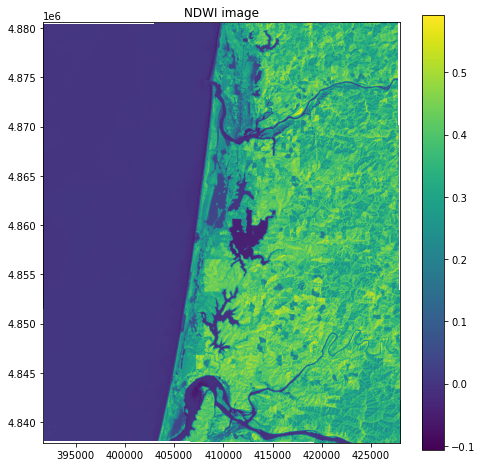

In [61]:
# Compute NDWI
np.seterr(divide='ignore', invalid='ignore')
ndwi = np.divide((all_bands[:,:,4].astype(float) - all_bands[:,:,3].astype(float)), \
                 (all_bands[:,:,4].astype(float) + all_bands[:,:,3].astype(float)))
# Plot NDWI image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(ndwi, extent=full_extent)
ax.set_title("NDWI image")
fig.colorbar(im, orientation='vertical')
plt.show()

# b) a color infrared composite (i.e. bands 5, 4, 3)

In [58]:
all_bands_image = np.uint8((all_bands /65536)*255)

In [59]:
infared = np.dstack((all_bands_image[:,:,4],all_bands_image[:,:,3,],all_bands_image[:,:,2]))

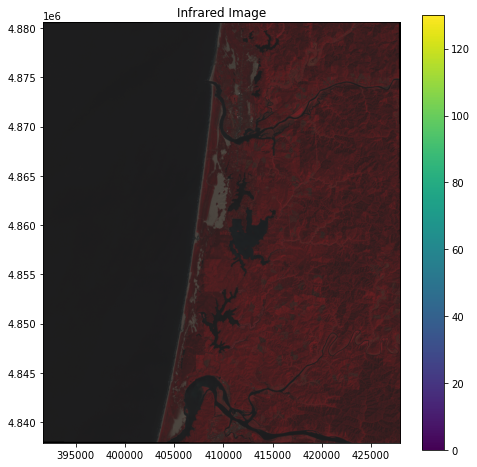

In [60]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(infared, extent=full_extent)
ax.set_title("Infrared Image")
fig.colorbar(im, orientation='vertical')
plt.show()